## Introduction

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plaintext review.

The dataset contains the following columns:

1. productId: The product ID of the reviewed item.
2. userId: The user ID of the reviewer.
3. profileName: The name of the reviewer's profile.
4. helpfulness: The number of helpful votes the review received.
5. score: The rating of the product (1-5 stars).
6. time: The date and time of the review.
7. summary: A short summary of the review.
8. text: The full text of the review.

The dataset can be used for a variety of purposes, such as:
1. Sentiment analysis: To determine the overall sentiment of the reviews (positive, negative, or neutral).
2. Topic modeling: To identify the topics that are discussed in the reviews.
3. Product recommendation: To recommend products to users based on their reviews.
4. Spam detection: To identify and remove spam reviews.

The Amazon Fine Food Reviews dataset is a valuable resource for anyone interested in understanding consumer behavior and the online review process. It is a large and comprehensive dataset that can be used to answer a variety of research questions.

### ***Project Objective: Visualize Amazon Reviews with Polarity Based Color Coding*** 

#### ***Discription:*** Amazon Fine Food Reviews dataset is a large dataset of reviews of fine foods from Amazon, we want to visualize 500,000 reviews in a 2D plane to understand how our reviews are distributed. We will use polarity of the review to visualize how positive and negative reviews are distributed.


#### ***Steps:***
1. Import necessary libraries
2. Data Cleaning and Storing the cleaned reviews in a new database
3. Convert reviews into vectors using Bag of Words, Tf-Idf and Word2Vec
4. Dimentionality Reduction using t-SNE

## 1. Importing Libraries and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
from nltk.stem.porter import PorterStemmer
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm import tqdm
from sklearn.manifold import TSNE

In [5]:
# opening a connection to database
con = sqlite3.connect('./AmazonFineFoodReviews/database.sqlite')

# querying database to get filtered data without 3 star review
# we are not considering the reviews with value of 3 as it is not a good indicator of polarity of review
data = pd.read_sql_query('SELECT * FROM Reviews WHERE Score !=3', con)
print(data.shape)
data.head(3)


(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


We will use the score column provided to get the polarity of the review.
1. reviews with score 4 and 5 will be considered positive
2. reviews with score 1 and 2 will be considered negative
3. we have dropped the reviews with value of 3 as it is not a good indicator of polarity of review

In [6]:
# convert score values to sentiment
def score_to_sentiment(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative' 

data['Score'] = data['Score'].apply(score_to_sentiment)    

## 2. Data Cleaning

Steps:
1. Sorting Data by ProductID
2. Deduplication
3. Helpfulness numerator should always be less than helpfulness denominator
4. Cleaning HTML Tags and Punctuation

In [8]:
# Sorting data acc to product ID
sorted_data = data.sort_values(by='ProductId', axis=0, ascending=True, kind='quicksort', na_position='last')

# Deduplication
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

# helpfulness numerator should always be less than helpfulness denominator
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('Shape of our data remaining:', final.shape)

# checking the percentage of data remaining
print('Percentage of Data Remaining:', (final.shape[0] / data.shape[0]) * 100)

Shape of our data remaining: (364171, 10)

Percentage of Data Remaining: 69.25852107399194


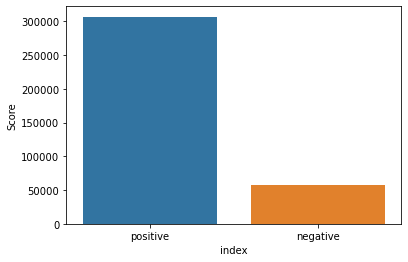

In [9]:
# let's check how positive and negative reviews are distributed
sns.barplot(data=final['Score'].value_counts().reset_index(), x='index', y='Score')
plt.show()

In [11]:
# find sentences containing HTML tags and punctuation
# we can see that there are a lot of unwanted elements in the raw text provided to us
# these elements will cause unnecessary dimensions in our vector conversions.
import re
i=0
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))) and (len(re.findall('[?|!|\'|"|#]', sent))):
        print('Index:', i)
        print(sent)
        break
    i += 1    

Index: 6

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [20]:
# source -> 
# 1. https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
# 2. https://datagy.io/python-remove-punctuation-from-string/

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

# function to clean the word of any punctuation or special characters
# please note that you can add any missed character using | operator
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]',r'',sentence)
    return  cleaned

res = cleanhtml(final['Text'].values[6])
res = cleanpunc(res)
print(res)

I set aside at least an hour each day to read to my son 3 yo At this point I consider myself a connoisseur of childrens books and this is one of the best Santa Clause put this under the tree Since then weve read it perpetually and he loves it  First this book taught him the months of the year  Second its a pleasure to read Well suited to 15 yo old to 4+  Very few childrens books are worth owning Most should be borrowed from the library This book however deserves a permanent spot on your shelf Sendaks best


In [27]:
# cleaning html, punct, stop-words and stemming each word from each review 
# please note that for Word2Vec we will not include all these steps for preprocessing.
# We store these final review in final.sqlite database

if not os.path.isfile('final.sqlite'):
    cleaned_reviews=[]
    cleaned_reviews_w2v = []
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        filtered_sentence_w2v = []
        sent = cleanhtml(sent)
        for word in sent.split():
            for cleaned_words in cleanpunc(word).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    filtered_sentence_w2v.append(cleaned_words.lower())
                    if(cleaned_words.lower() not in stop):
                        stem_word=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(stem_word)
        filtered_sentence = b' '.join(filtered_sentence)
        filtered_sentence_w2v = ' '.join(filtered_sentence_w2v)   
        cleaned_reviews.append(filtered_sentence)  
        cleaned_reviews_w2v.append(filtered_sentence_w2v)
    final['CleanedText']=cleaned_reviews 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    final['CleanedText_w2v'] = cleaned_reviews_w2v
    
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    print('Done..!!')

else:
    print('File already Exist')          

100%|██████████| 364171/364171 [08:33<00:00, 709.27it/s] 


Done..!!


## 3. Convert Text Reviews Into Vectors

### ***Objective:*** Convert Each Review or sentence into a vector.

In this section we will convert out cleaned reviews to vectors so that we can represent them in a n-dimensional plane and then reduce the dimentionality using Tsne to visualize them in 2 dimensions. Below are the ways we will convert our reviews to vectors


***Bag of Words:*** The bag-of-words (BoW) model is a simple yet effective approach used in natural language processing (NLP) to represent text data numerically. It treats a document as an unordered collection or "bag" of words, disregarding grammar, word order, and context. Instead, it focuses solely on the presence and frequency of words in the text.

***TF-IDF:*** TF-IDF (Term Frequency-Inverse Document Frequency) is a widely used weighting scheme in natural language processing (NLP) that provides a numerical representation for words in a document corpus. It aims to capture the importance of a word in a document relative to the entire corpus. TF-IDF combines two metrics: term frequency (TF) and inverse document frequency (IDF).

* Term Frequency (TF): TF measures the frequency of a word in a document. It assigns higher weights to words that appear more frequently within a document. The intuition behind TF is that words occurring more often in a document could be more significant or indicative of its content.

* Inverse Document Frequency (IDF): IDF measures the rarity of a word across the document corpus. It assigns higher weights to words that are less common across documents in the corpus. The rationale behind IDF is that rare words often carry more informational value compared to common words like "the" or "and."

In [3]:
# reading our cleaned reviews from final database

if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews """, conn)
    conn.close()
else:
    print("File Not Available in the location")

In [4]:
# we will now operate on 5k datapoints, because of memory limitations 
# the code can be scaled for all 364171 data points as well

positive_5k = final[final['Score'] == 'positive'][:2500]
negative_5k = final[final['Score'] == 'negative'][:2500]
print(positive_5k.shape)
print(negative_5k.shape)

df_5k = pd.concat([positive_5k, negative_5k], axis=0)
df_5k = df_5k.sample(frac=1)
print(df_5k.shape)
print(df_5k['Score'].value_counts())

(2500, 13)

(2500, 13)

(5000, 13)

negative    2500

positive    2500

Name: Score, dtype: int64


In [5]:
# change the score to 1 and 0  at the top
# 1 = positive

# Bag of Words

vectorizer_bow = CountVectorizer()
vectorizer_bow.fit(final['CleanedText'].values)
bow_data = vectorizer_bow.transform(df_5k['CleanedText'].values)
bow_standerdised_data = StandardScaler().fit_transform(bow_data.toarray())

print(type(bow_standerdised_data))
print(bow_standerdised_data.shape)


# TFIDF

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(final['CleanedText'].values)
tfidf_data = vectorizer_tfidf.transform(df_5k['CleanedText'].values)
tfidf_standerdised_data = StandardScaler().fit_transform(tfidf_data.toarray())

print(type(tfidf_standerdised_data))
print(tfidf_standerdised_data.shape)

<class 'numpy.ndarray'>

(5000, 120723)

<class 'numpy.ndarray'>

(5000, 120723)


## Text to Vector Conversion With Word2Vec 
***Word2Vec:*** Word2Vec is a widely used algorithm in natural language processing (NLP) that learns word embeddings, which are dense numerical representations of words. It is based on the idea that words with similar meanings often appear in similar contexts. Word2Vec captures these relationships by learning to predict a word based on its neighboring words or predicting neighboring words based on a given word. There are two ways we will be using Word2Vec to convert our sentence

1. ***Average Word2Vec:*** In the case of Average Word2Vec, the goal is to create a fixed-length vector representation for a document by averaging the word vectors of all the words in the document.

2. ***TF-IDF Weighted Word2Vec:*** TF-IDF weighted Word2Vec combines the concepts of TF-IDF and Word2Vec to create word embeddings that capture both the semantic meaning of words and their importance within a document corpus. It enhances the traditional Word2Vec model by incorporating the term frequency-inverse document frequency (TF-IDF) weighting scheme.

In [26]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [23]:
# we have already cleaned our reviews for Word2Vec
# now generate the data-structure suitable for the input of Word2Vec model
# required data structure => [[this], [is], [a], [review]]

def datastructure_generator_w2v(df):
    list_of_reviews = []
    for sent in tqdm(df['CleanedText_w2v'].values):
        list_of_reviews.append(sent.split())
    return list_of_reviews

In [24]:
# constructing required structures 

list_of_sent =  datastructure_generator_w2v(final)
list_of_sent_10k = datastructure_generator_w2v(df_5k)
list_of_sent_idf = final['CleanedText_w2v']
list_of_sent_idf10k = df_5k['CleanedText_w2v']
print('Done..!!')

100%|██████████| 364171/364171 [00:10<00:00, 35705.21it/s]

100%|██████████| 5000/5000 [00:00<00:00, 44437.40it/s]

Done..!!


In [27]:
# training Word2Vec model on our data
# this may take time to execute 

model_w2v=Word2Vec(list_of_sent,min_count=5,vector_size=50, workers=2)

In [28]:
# generating tfidf values
vectorizer_tfidf_w2v = TfidfVectorizer()
vectorizer_tfidf_w2v.fit(list_of_sent_idf)
tfidf_data_w2v = vectorizer_tfidf_w2v.transform(list_of_sent_idf10k)

In [29]:
# construct avg w2v

vocabulary_w2v = model_w2v.wv.key_to_index.keys()
review_vectors_w2v = []

for sentence in tqdm(list_of_sent_10k):
    word_count = 0
    sent_vec = np.zeros(shape=50)
    for word in sentence:
        if word in vocabulary_w2v:
            sent_vec += model_w2v.wv[word]
            word_count += 1
    
    if word_count != 0:
        sent_vec = sent_vec/word_count
    review_vectors_w2v.append(sent_vec) 
review_vectors_w2v = np.array(review_vectors_w2v)       
print(review_vectors_w2v.shape)

100%|██████████| 5000/5000 [00:02<00:00, 1899.04it/s]

(5000, 50)


In [30]:
# constructing tf-idf weighted Word2Vec

tfidf_feature_names = vectorizer_tfidf_w2v.get_feature_names()

w2v_tfidf_data = []
for i,sentence in enumerate(tqdm(list_of_sent_10k)):
    tfidf_weight = 0
    sent_vec = np.zeros(shape=50)
    for word in sentence:
        try:
            tfidf_value = tfidf_data_w2v[i,tfidf_feature_names.index(word)]
            w2v_vector = model_w2v.wv[word]
            sent_vec += tfidf_value * w2v_vector
            tfidf_weight += tfidf_value
        except:
            pass

    sent_vec = sent_vec / tfidf_weight
    w2v_tfidf_data.append(sent_vec)

w2v_tfidf_data = np.array(w2v_tfidf_data)
print(w2v_tfidf_data.shape)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

  warnings.warn(msg, category=FutureWarning)

100%|██████████| 5000/5000 [31:19<00:00,  2.66it/s]  

(5000, 50)


## 4. Dimentionality Reduction and Visualization with TSNE

In this section we will use our review vectors and use t-SNE to map our high dimentional data points (reviews) to 2-Dimentional space and visualize them. 
The dimentions of our vector are listed below

1. Bag of Words: 120723
2. TF-IDF: 120723
3. Agerage Word2Vec: 50
4. TF-IDF Weighted Word2Vec: 50

***t-SNE (t-Distributed Stochastic Neighbor Embedding)*** is a dimensionality reduction technique commonly used in machine learning and data visualization. It is particularly useful for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D, in order to identify patterns and clusters.

The t-SNE algorithm takes a set of high-dimensional data points as input and maps them to a lower-dimensional space while preserving the local structure of the data. It achieves this by modeling pairwise similarities between data points in the high-dimensional space and attempting to preserve these similarities in the lower-dimensional embedding.

t-SNE is often used for visualizing complex and high-dimensional datasets, such as images or word embeddings. By reducing the dimensionality of the data while preserving the local structure, t-SNE can reveal interesting patterns, clusters, and relationships that may not be easily discernible in the original high-dimensional space.

In [ ]:
# creating a function to visualize TSNE results 

def tsne_visualizer(data, label, title):
    # TSNE
    from sklearn.manifold import TSNE

    tsne_model = TSNE(n_components=2, n_iter=2000)
    tsne_data = tsne_model.fit_transform(data)

    tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, label)).T, columns=['1st_component', '2nd_component', 'label'])
    tsne_df

    sns.scatterplot(data=tsne_df, x='1st_component', y='2nd_component', hue='label')
    plt.title(title)
    plt.show()

# tsne_visualizer(data=bow_standerdised_data, label=df_final['Score'].values)   

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  warnings.warn(

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  warnings.warn(


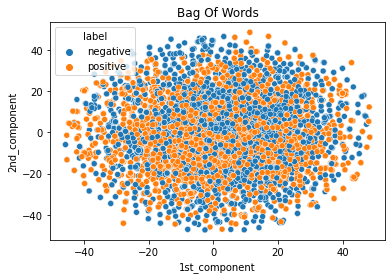

In [34]:
# visualizing Bag of Words with TSNE

title = 'Bag Of Words'
tsne_visualizer(data=bow_standerdised_data, label=df_5k['Score'].values, title=title) 

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  warnings.warn(

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  warnings.warn(


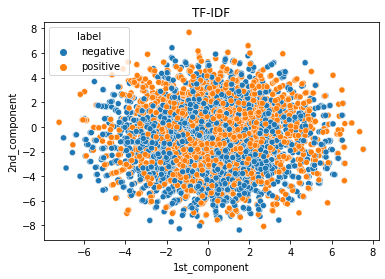

In [35]:
## visualizing TF-IDF with TSNE

title = 'TF-IDF'
tsne_visualizer(data=tfidf_standerdised_data, label=df_5k['Score'].values, title=title)  

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  warnings.warn(

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  warnings.warn(


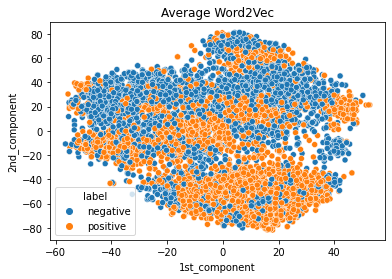

In [32]:
# visualizing average word2vec with TSNE

std_avgw2v_data = StandardScaler().fit_transform(review_vectors_w2v)
title = 'Average Word2Vec'
tsne_visualizer(data=std_avgw2v_data, label=df_5k['Score'].values, title=title)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

  warnings.warn(

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

  warnings.warn(


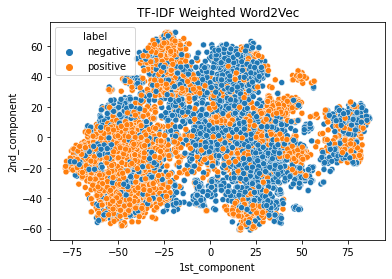

In [33]:
# visualizing TF-IDF weighted word2vec with TSNE

std_tfidfw2v_data = StandardScaler().fit_transform(w2v_tfidf_data)
title = 'TF-IDF Weighted Word2Vec'
tsne_visualizer(data=std_tfidfw2v_data, label=df_5k['Score'].values, title=title)